The purpose of this notebook is to build sklearn-like pipeline for transformation

In [1]:
import pandas as pd         
import os.path

In [2]:
def load_data(path="../data/csv/all.csv"):
    dataframe = pd.read_csv(path, index_col=0)
    return dataframe.loc[~dataframe["execTimeMs"].isnull()]

In [3]:
def prepare_dataframe(dataframe):
    output = dataframe.dropna(axis="columns")
    targets = output["execTimeMs"]
    dropped = output[["command", "execTimeMs", "jobId", "ctime_mean", "ctime_max", "ctime_sum", "read_sum","write_sum","readSyscalls_sum","writeSyscalls_sum","readReal_sum","writeReal_sum","writeCancelled_sum","rxBytes_sum","rxPackets_sum","rxErrors_sum","rxDrop_sum","rxFifo_sum","rxFrame_sum","rxCompressed_sum","rxMulticast_sum","txBytes_sum","txPackets_sum","txErrors_sum","txDrop_sum","txFifo_sum","txColls_sum","txCarrier_sum","txCompressed_sum","cpu_mean","cpu_max","memory_mean","memory_max"]]
    features = output.drop(dropped.columns, axis=1)
    return features, targets, dropped

In [4]:
features, targets, _ = prepare_dataframe(load_data())

In [5]:
features.dtypes

workflowName          object
size                 float64
executable            object
args                  object
inputs                object
outputs               object
name                  object
cpu.manufacturer      object
cpu.brand             object
cpu.speed            float64
cpu.cores              int64
cpu.physicalCores      int64
cpu.processors         int64
mem.total              int64
mem.free               int64
mem.used               int64
mem.active             int64
mem.available          int64
mem.buffers            int64
mem.cached             int64
mem.slab               int64
mem.buffcache          int64
mem.swaptotal          int64
mem.swapused           int64
mem.swapfree           int64
dtype: object

# Preprocessing flow

In [6]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector as selector

In [7]:
def vectorize_list(series):
    def vectorize(list_string):
        return len(eval(list_string))
    return np.vectorize(vectorize)(series)

def ListTransformer():
    return FunctionTransformer(func=vectorize_list)

In [8]:
list_transformer = Pipeline(steps=[("list", ListTransformer()), ("scaler", StandardScaler())])
list_features = list(['args', 'inputs', 'outputs'])

numerical_transformer = StandardScaler()
numerical_features = list(features.select_dtypes(include="number").columns)
enhanced_numerical_features = numerical_features + ["read_sum", "write_sum", "cpu_mean", "memory_max"]

categorical_transformer = OneHotEncoder(sparse=False, handle_unknown = "ignore")
categorical_features = list(set(features.select_dtypes(include="object").columns) ^ set(list_features))
enhanced_categorical_features = categorical_features +  ["read_sum", "write_sum", "cpu_mean", "memory_max"]

preprocessor = ColumnTransformer(
    transformers=[
        ('lists', list_transformer, list_features),
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

enh_numerical_preprocessor = ColumnTransformer(
    transformers=[
        ('lists', list_transformer, list_features),
        ('num', numerical_transformer, enhanced_numerical_features),
        ('cat', categorical_transformer, categorical_features)])

enhanced_preprocessor = ColumnTransformer(
    transformers=[
        ('lists', list_transformer, list_features),
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, enhanced_categorical_features)]
)

In [9]:
from scipy.stats import percentileofscore
import math

def calculate_quantile_rank(labels, label):
    return percentileofscore(labels, label) / 100

def calculate_utilization_class(labels, label):
    def label_for_rank(rank):
        if rank > 0.75:
            return 'very high'
        elif rank > 0.5:
            return 'high'
        elif rank > 0.25:
            return 'medium'
        else:
            return 'low'
    return label_for_rank(calculate_quantile_rank(labels, label))

def calculate_utilization_bucket(labels, label, num_buckets):
    bucket_size = 1.0 / num_buckets
    def bucket_for_rank(rank):
        return str(math.floor(rank / bucket_size))
    return bucket_for_rank(calculate_quantile_rank(labels, label))

# Pipeline composition (with PCA)

In [10]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso, SGDRegressor, ElasticNet, LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingGridSearchCV

In [11]:
base_steps = [('pca', PCA(random_state=42))]
dummy_pipeline = Pipeline(steps=base_steps +[('dummy', DummyRegressor())])
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=0)

In [12]:
pca_param_grid = {
    'pca__n_components': np.arange(1, 50, 3),    
}
knn_param_grid = {
    'knn__n_neighbors': np.arange(1, 30, 3),
}
regressor = ('knn', KNeighborsRegressor())
full_pipeline = Pipeline(steps= base_steps + [regressor])
grid_search = HalvingGridSearchCV(full_pipeline, {**knn_param_grid, **pca_param_grid}, cv=2, verbose=2, scoring="r2", n_jobs=-1)

In [13]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error


def rate_regressor(X_train, y_train, X_test, y_test, regressor, regressor_params, verbose=2, aggressive_elimination=True, steps=base_steps):
    print(f"Rating {regressor}")
    full_pipeline = Pipeline(steps= base_steps + [regressor])
    vector_length = X_train.shape[1]
    pca_param_grid = {'pca__n_components': np.arange(1, vector_length, 1),}
    grid_search = HalvingGridSearchCV(full_pipeline, {**pca_param_grid, **regressor_params}, cv=2, verbose=verbose, scoring="r2", n_jobs=3, aggressive_elimination=aggressive_elimination)
    grid_search.fit(X_train, y_train)
    
    # scores
    prediction = grid_search.best_estimator_.predict(X_test)
    
    r2 = r2_score(y_test, prediction)
    adjusted_r2 = 1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
    mae = mean_absolute_error(y_test, prediction)
    mape = mean_absolute_percentage_error(y_test, prediction)
    
    return {"r2": r2, "adjusted_r2": adjusted_r2, "mae": mae, "mape": mape,"best_score": grid_search.best_score_, "params": grid_search.best_params_}

# Here go regressor params

In [14]:
knn = ("knn", KNeighborsRegressor())
knn_params = {'knn__n_neighbors': np.arange(1, 30, 2)}

dtr = ("dtr", DecisionTreeRegressor(random_state=5))
dtr_params = {"dtr__criterion": ["mse", "friedman_mse", "mae", "poisson"]}

# mlp = ("mlp", MLPRegressor())
# mlp_params = {"mlp__hidden_layer_sizes": np.arange(1,200, 10),
# #                 "mlp__activation": ["logistic", "tanh", "relu"],
#              "mlp__alpha": np.arange(0.01, 0.1, 0.01)}

lasso = ("lasso", Lasso(random_state=5))
lasso_params = {"lasso__alpha": np.arange(0.01, 1, 0.05)}

en = ("elasticnet", ElasticNet(random_state=5))
en_params = {"elasticnet__alpha": np.arange(0.01, 1, 0.05), "elasticnet__l1_ratio": np.arange(0, 1, 0.1)}

svr = ("svr", SGDRegressor())
svr_params = {"svr__loss": ["squared_loss", "huber", "epsilon_insensitive"], "svr__penalty": ['l2', 'l1', 'elasticnet'],
             "svr__alpha": np.arange(0.0001, 0.2, 0.01), "svr__max_iter": [10000]}

rf = ("rf", RandomForestRegressor())
rf_params = {"rf__n_estimators": np.arange(5, 100, 5), "rf__criterion": ["mae", "mse"], "rf__max_features": ["auto", "sqrt", "log2"]}

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
def make_datasets(dataframe):
    jobs_below_1200ms = dataframe.loc[dataframe["execTimeMs"] < 1200]
    jobs_between_2000ms_25000ms = dataframe.loc[dataframe["execTimeMs"].between(2000, 25000)]
    jobs_count = dataframe["name"].value_counts()
    jobs_most_occuring = dataframe.loc[dataframe["name"].isin(jobs_count[jobs_count > 3000].index.values)]
    jobs_mDiffFit = dataframe.loc[dataframe["name"] == "mDiffFit"]
    jobs_haplotype = dataframe.loc[dataframe["name"] == "haplotype_caller"]
    jobs_mShrink = dataframe.loc[dataframe["name"] == "mShrink"]
    return jobs_below_1200ms, jobs_between_2000ms_25000ms, jobs_most_occuring

In [17]:
datasets = make_datasets(load_data())

In [18]:
dfs_for_jobs = [pd.DataFrame(y) for x, y in load_data().groupby('name', as_index=False)]

In [19]:
def rate_data(features, targets, regressors, verbose=2, pipeline_steps=base_steps):
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=0)
    df = pd.DataFrame(columns=["name", "pca", "adjusted_r2","r2", "mae", "mape", "best_score", "params"])
    for (regressor, params) in regressors:
        result = rate_regressor(X_train, y_train, X_test, y_test, regressor, params, verbose, pipeline_steps)
        df = df.append({"name": regressor[0], **result, "pca": result["params"]["pca__n_components"]}, ignore_index=True)
    return df

In [20]:
def rate_dataset(dataframe, regressors, verbose=2):
    print(f"Rating dataset of len {len(dataframe)}")
    features, targets, _ = prepare_dataframe(dataframe[:10000])
    rate_data(features, targets, regressors, verbose)

In [21]:
basic_regressors = [
    (knn, knn_params),
    (dtr, dtr_params),
    (lasso, lasso_params),
    (en, en_params),
    (svr, svr_params),
##     (rf, rf_params)
]

In [22]:
def simple_experiment():
    print("Rating jobs datasets")
    for dataset in dfs_for_jobs:
        print(dataset.iloc[0]["name"])
        rate_dataset(dataset, basic_regressors)

    print("Rating common datasets")
    for dataset in datasets:
        rate_dataset(dataset, basic_regressors)

In [23]:
# rate_dataset(dfs_for_jobs[8], verbose=0)
#rate_dataset(dfs_for_jobs[1], basic_regressors, verbose=0)

## Z powyższego mikroeksperymentu - KNN i Lasso jako testowe

## Eksperyment 1

### Cel

Dowiedzieć się jakiego pipelinu użyć do predykcji czasu obliczeń

### Dane 
krótsze niż 1200ms, 2k-25k ms, częstsze niż 3000, wszystkie

In [92]:
raw_dataframe = load_data()
jobs_count = raw_dataframe["name"].value_counts()
exp1_datasets = {
    "ShorterThan1.2Kms": raw_dataframe.loc[raw_dataframe["execTimeMs"] < 1200],
    "Between2KmsAnd25Kms": raw_dataframe.loc[raw_dataframe["execTimeMs"].between(2000, 25000)],
    "ExecutedMoreThan3Ktimes": raw_dataframe.loc[raw_dataframe["name"].isin(jobs_count[jobs_count > 3000].index.values)],
    "All": raw_dataframe
}

def get_pipeline1_data(data):
    """
    Simply raw data, without any enhancement
    """
    features, labels, _ = prepare_dataframe(data)
    features = preprocessor.fit_transform(features)
    return features, labels

def get_pipeline2_data(data):
    """
    Raw data enhanced with resource utilization classes (read, write, cpu, ram), but classes are assigned - not predicted
    """
    features, labels, dropped = prepare_dataframe(data)
    ranked_columns = ["read_sum", "write_sum", "cpu_mean", "memory_max"]
    for column in ranked_columns:
        features[column] = dropped[column].map(lambda value: calculate_utilization_class(dropped[column], value))
    features = enhanced_preprocessor.fit_transform(features)
    return features, labels

def get_pipeline3_data(data, cpu_metric="cpu_mean"):
    """
    Raw data enhanced with resource utilization quantile scores (read, write, cpu, ram), but scores are assigned - not predicted
    """
    features, labels, dropped = prepare_dataframe(data)
    ranked_columns = ["read_sum", "write_sum", cpu_metric, "memory_max"]
    for column in ranked_columns:
        features[column] = dropped[column].map(lambda value: calculate_quantile_rank(dropped[column], value))
    features = enh_numerical_preprocessor.fit_transform(features)
    return features, labels

def get_pipeline4_data(data, num_buckets=5, cpu_metric="cpu_mean"):
    """
    Raw data enhanced with resource utilization buckets (read, write, cpu, ram), but classes are assigned - not predicted
    There are 4 possible utilization classes, but number of buckets is configurable.
    get_pipeline4_data(d, 4) == get_pipeline2_data(d)
    """
    features, labels, dropped = prepare_dataframe(data)
    ranked_columns = ["read_sum", "write_sum", cpu_metric, "memory_max"]
    for column in ranked_columns:
        features[column] = dropped[column].map(lambda value: calculate_utilization_bucket(dropped[column], value, num_buckets))
    features = enhanced_preprocessor.fit_transform(features)
    return features, labels

### Przebieg
dla każdego zbioru sprawdzamy, który pipeline jest lepszy i w jakim wariancie

In [25]:
def run_experiment1a():
    full_df = pd.DataFrame(columns=["dataset", "pipeline", "name", "pca", "adjusted_r2","r2", "mae", "mape", "best_score", "params"])
    for name, dataset in exp1_datasets.items():
        print(f"Evaluating dataset {name} of length {len(dataset)}")
        def run_pipeline(name, features, targets):
            pipeline_df = rate_data(features, targets, basic_regressors, verbose=0)
            pipeline_df["pipeline"] = name
            return pipeline_df
        dataset_df = pd.concat([
            run_pipeline("simple", *get_pipeline1_data(dataset)),
            run_pipeline("two_step_4_cat", *get_pipeline2_data(dataset)),
            run_pipeline("two_step_continuous", *get_pipeline3_data(dataset)),
            run_pipeline("two_step_5_cat", *get_pipeline4_data(dataset, 5)),
            run_pipeline("two_step_6_cat", *get_pipeline4_data(dataset, 6)),
            run_pipeline("two_step_7_cat", *get_pipeline4_data(dataset, 7)),
            run_pipeline("two_step_8_cat", *get_pipeline4_data(dataset, 8)),
            run_pipeline("two_step_9_cat", *get_pipeline4_data(dataset, 9)),
            run_pipeline("two_step_10_cat", *get_pipeline4_data(dataset, 10)),
        ])
        dataset_df["dataset"] = name
        full_df = full_df.append(dataset_df)
    return full_df

def run_experiment1b():
    full_df = pd.DataFrame(columns=["dataset", "pipeline", "name", "pca", "adjusted_r2","r2", "mae", "mape", "best_score", "params"])
    for name, dataset in exp1_datasets.items():
        print(f"Evaluating dataset {name} of length {len(dataset)}")
        def run_pipeline(name, features, targets):
            pipeline_df = rate_data(features, targets, basic_regressors, verbose=0)
            pipeline_df["pipeline"] = name
            return pipeline_df
        dataset_df = pd.concat([
            run_pipeline("two_step_continuous_cpu_max", *get_pipeline3_data(dataset), "cpu_max"),
            run_pipeline("two_step_8_cat_cpu_max", *get_pipeline4_data(dataset, 8, "cpu_max")),
            run_pipeline("two_step_9_cat_cpu_max", *get_pipeline4_data(dataset, 9), "cpu_max"),
            run_pipeline("two_step_10_cat_cpu_max", *get_pipeline4_data(dataset, 10), "cpu_max"),
            run_pipeline("two_step_continuous_ctime_sum", *get_pipeline3_data(dataset), "ctime_sum"),
            run_pipeline("two_step_8_cat_ctime_sum", *get_pipeline4_data(dataset, 8, "ctime_sum")),
            run_pipeline("two_step_9_cat_ctime_sum", *get_pipeline4_data(dataset, 9), "ctime_sum"),
            run_pipeline("two_step_10_cat_ctime_sum", *get_pipeline4_data(dataset, 10), "ctime_sum"),
        ])
        dataset_df["dataset"] = name
        full_df = full_df.append(dataset_df)
    return full_df

In [26]:
if not os.path.isfile("exp1.csv"):
    exp1a_df = run_experiment1a()
    # exp1_df.to_csv("exp1.csv")
else:
    exp1a_df = pd.read_csv("exp1.csv").round(2)

if not os.path.isfile("exp1b.csv"):
    exp1b_df = run_experiment1b()
    # exp1_df.to_csv("exp1.csv")
else:
    exp1b_df = pd.read_csv("exp1b.csv").round(2)

exp1_df = pd.concat([exp1a_df, exp1b_df])

In [27]:
exp1_df.head()

,Unnamed: 0,dataset,pipeline,name,pca,adjusted_r2,r2,mae,mape,best_score,params
0,0,ShorterThan1.2Kms,simple,knn,43,0.73,0.73,76.63,0.34,0.72,"{'knn__n_neighbors': 5, 'pca__n_components': 43}"
1,1,ShorterThan1.2Kms,simple,dtr,36,0.54,0.54,95.61,0.43,0.53,"{'dtr__criterion': 'mse', 'pca__n_components':..."
2,2,ShorterThan1.2Kms,simple,lasso,40,0.63,0.63,105.26,0.54,0.62,"{'lasso__alpha': 0.66, 'pca__n_components': 40}"
3,3,ShorterThan1.2Kms,simple,elasticnet,40,0.62,0.62,107.61,0.57,0.62,"{'elasticnet__alpha': 0.060000000000000005, 'e..."
4,4,ShorterThan1.2Kms,simple,svr,28,0.64,0.64,103.57,0.51,0.63,"{'pca__n_components': 28, 'svr__alpha': 0.0001..."


### Output eksperymentu
#### Wykresy

wykresy: R^2, MAE i MAPE dla każdego zbioru i każdego pipeline'u (powiedzmy że dla 3 najlepszych z każdego)

In [28]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 20)})

In [33]:
def bar(data, x, y, hue, order):
    plt = sns.catplot(x=x, y=y, hue=hue, kind="bar", data=data, height=14, aspect=3, hue_order=order, ci=None)
    plt.set(yscale="log")
    return plt

In [34]:
def errors_df(df, err, fun=lambda df: df.idxmin()):
    return df.iloc[fun(df.groupby(["pipeline", "dataset"])[err])]

In [35]:
pipeline_order=["simple","two_step_4_cat","two_step_5_cat","two_step_6_cat","two_step_7_cat","two_step_8_cat","two_step_9_cat","two_step_10_cat", "two_step_continuous"]

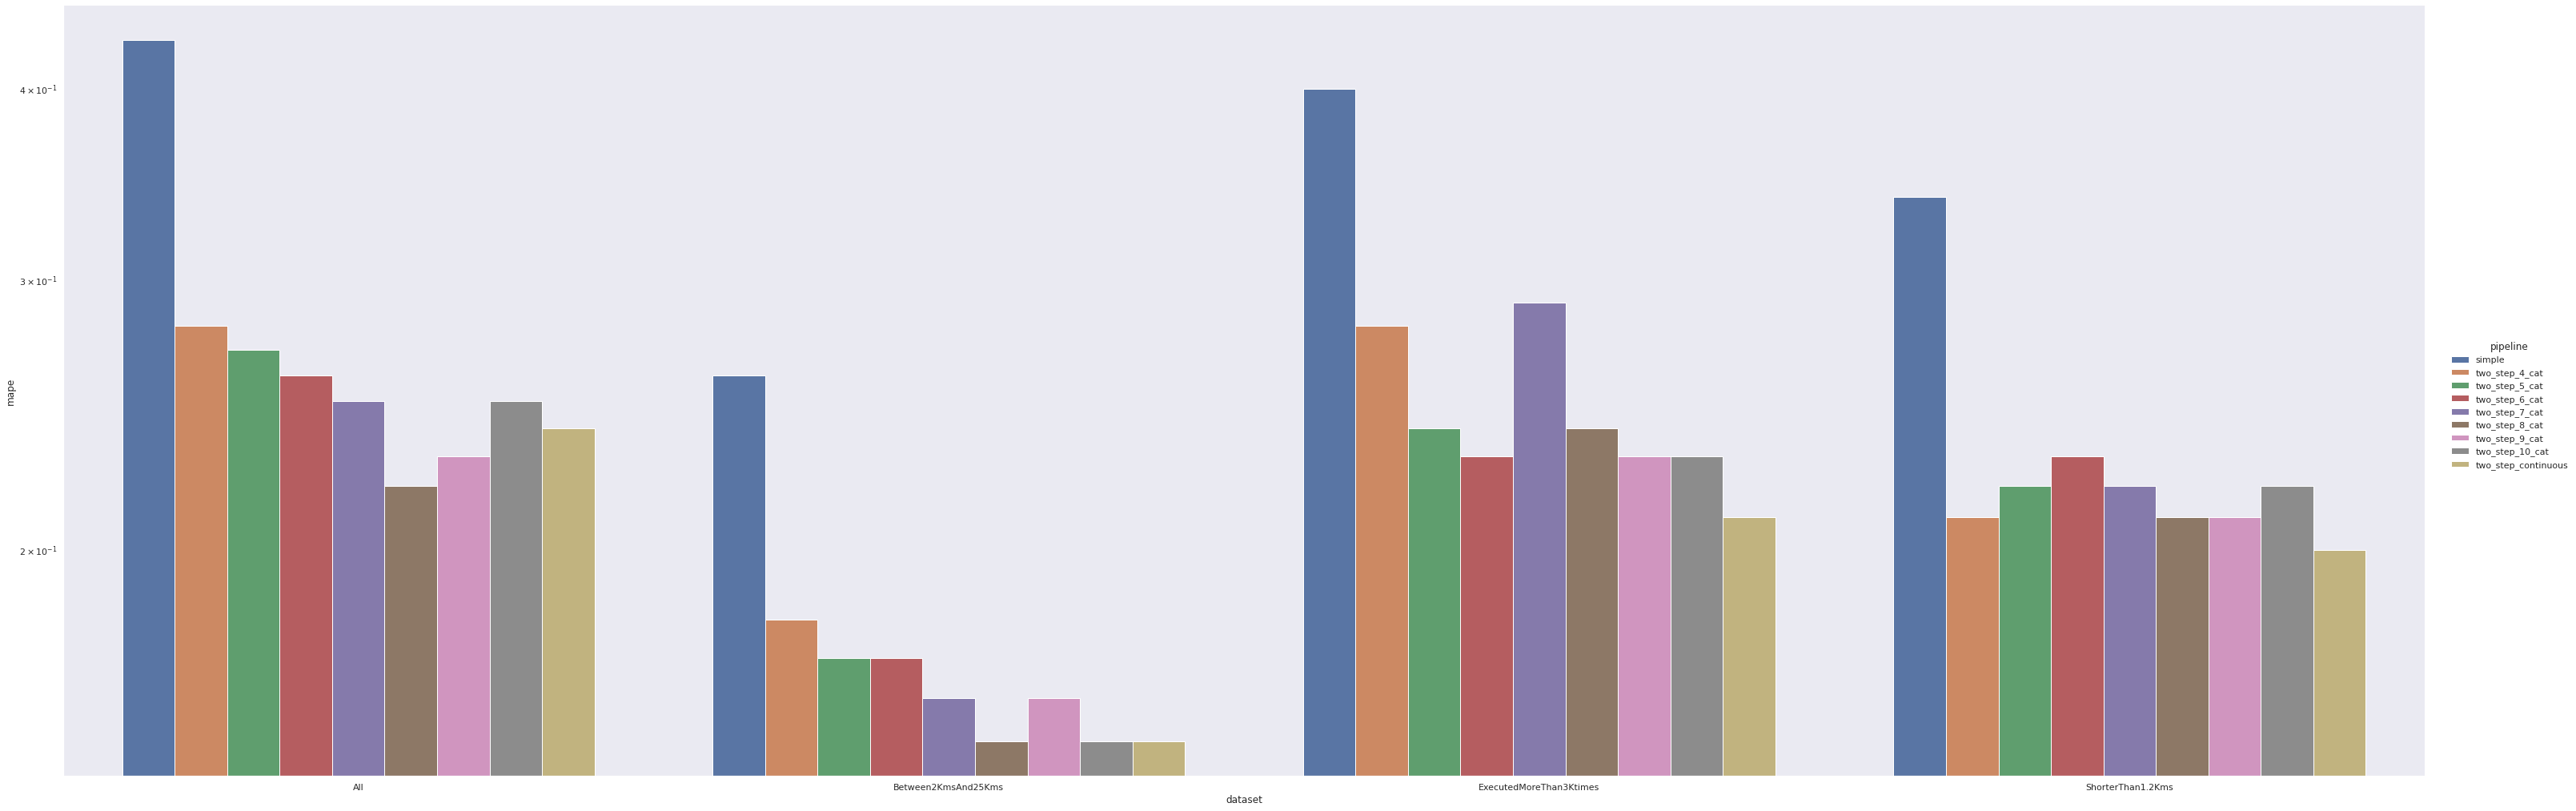

In [37]:
bar(errors_df(exp1_df, "mape"), "dataset", "mape", "pipeline", pipeline_order)

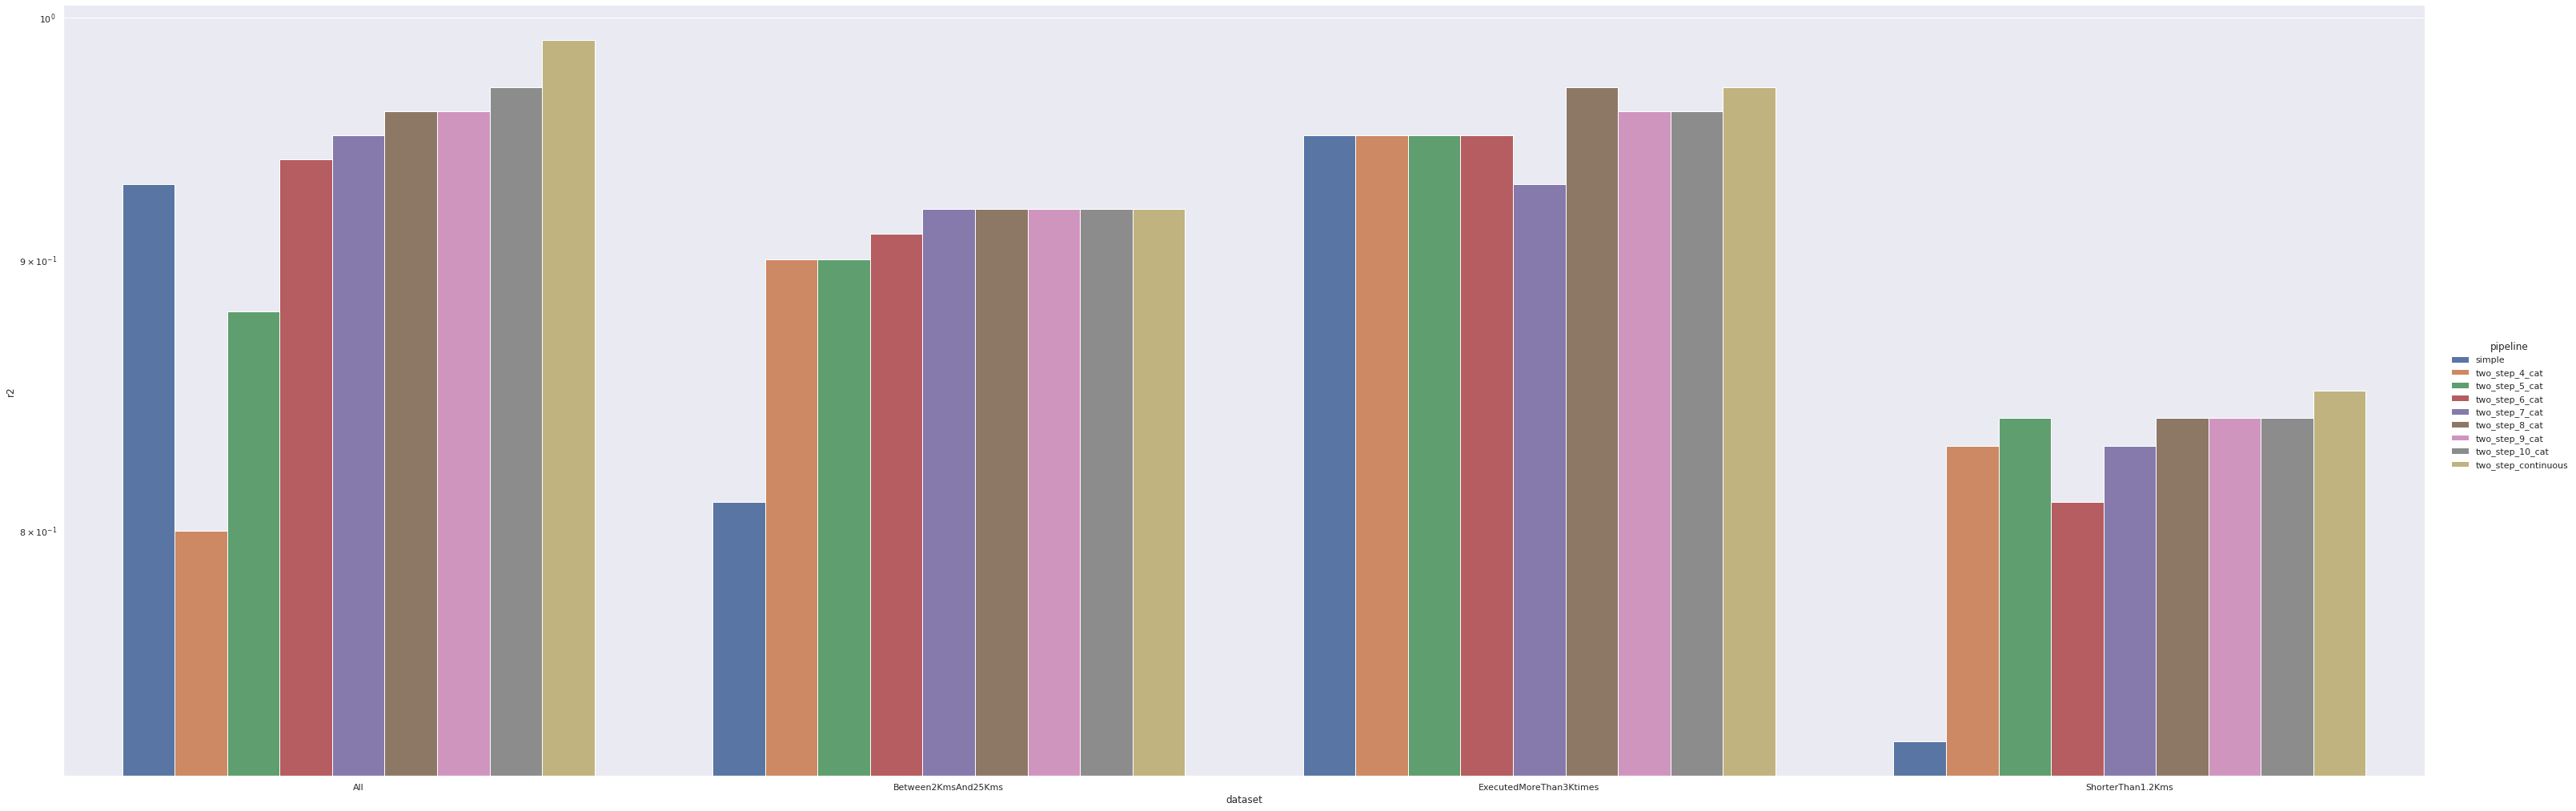

In [38]:
bar(errors_df(exp1_df, "r2", lambda df: df.idxmax()), "dataset", "r2", "pipeline", pipeline_order)

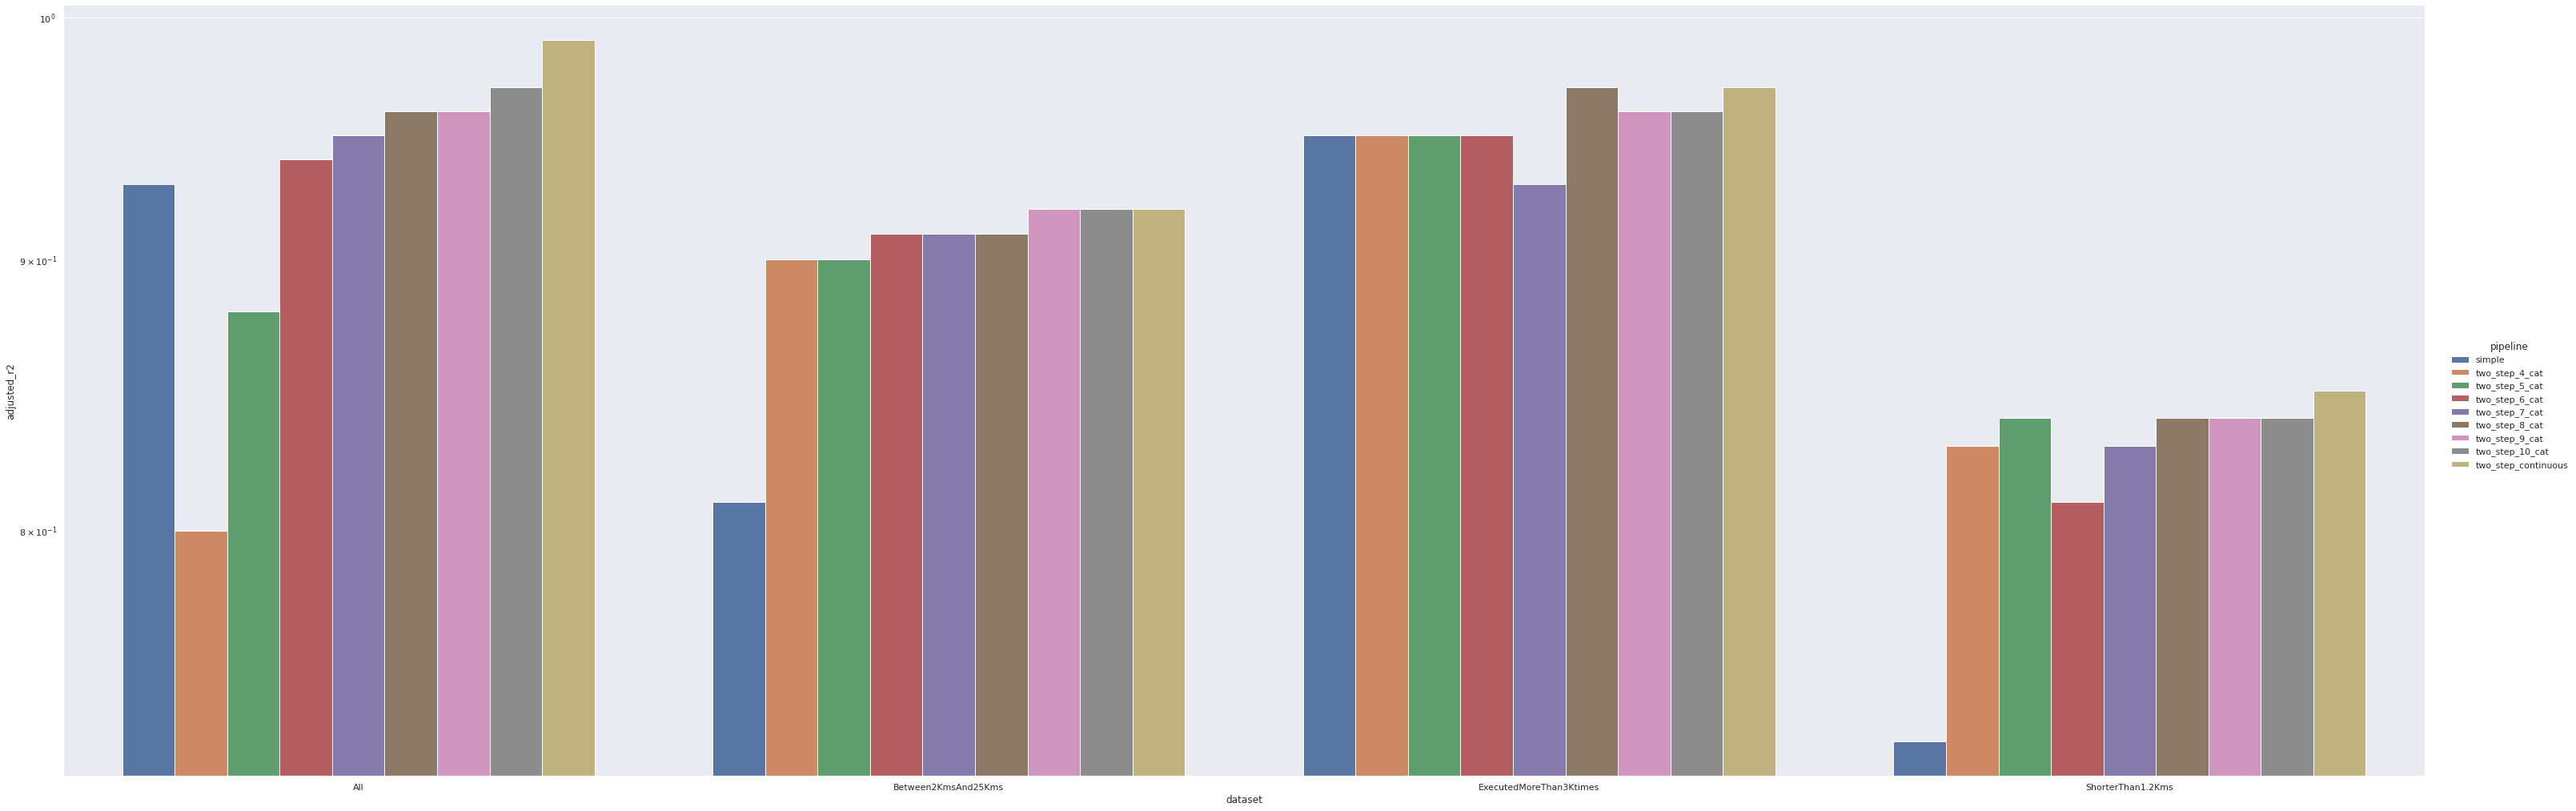

In [39]:
bar(errors_df(exp1_df, "adjusted_r2", lambda df: df.idxmax()), "dataset", "adjusted_r2", "pipeline", pipeline_order)

In [150]:
# exp1_df.iloc[exp1_df.groupby("dataset")["r2"].idxmax()]
# exp1_df.iloc[exp1_df.groupby("dataset")["mape"].idxmax()]
# exp1_df[exp1_df["dataset"] =="All"].sort_values("r2", ascending=False)

#### Odpowiedzi

odpowiedzi: czy I, czy II, czy dzielić na więcej niż 4 kategorie

# Follow up
#### Odpalić testy z dzieleniem na od 10 d0 20, jeżeli nie pyknie - ciągłe albo na 8 kubełków
#### Odpalić testy z cpu_maxem, zamiast cpu_meanem
#### Odpalić testy z ctime_sum, zamist cpu_meanem

***

## Eksperyment 2

### Cel

Dowiedzieć się jakich regresorów i klasyfikatorów używać do przewidywania poziomów zasobów

### Dane
krótsze niż 1200ms, 2k-25k ms, częstsze niż 3000, wszystkie

In [87]:
exp2_datasets = exp1_datasets

def exp2_pipeline1_data(data, resource):
    """
    Raw data and targets are ${resource} expressed as quantile rank
    """
    features, _, dropped = prepare_dataframe(data)
    labels = dropped[resource].map(lambda value: calculate_quantile_rank(dropped[resource], value))
    features = preprocessor.fit_transform(features)
    labels = pd.DataFrame(labels)
    return features, labels

def exp2_pipeline2_data(data, resource, num_buckets=8):
    """
    Raw data and targets are ${resource} expressed as usage bucket label
    """
    features, _, dropped = prepare_dataframe(data)
    labels = pd.DataFrame(dropped[resource].map(lambda value: calculate_utilization_bucket(dropped[resource], value, num_buckets)))
    features = preprocessor.fit_transform(features)
    return features, labels

In [88]:
ranked_columns = ["read_sum", "write_sum", "cpu_mean", "memory_max"]

### Przebieg

Znajdujemy najlepszy regresor dla każdego typu zasobów 

Znajdujemy najlepszy klasyfikator dla każdego typu zasobów przy 8 kubełkach


### Output eksperymentu
Regresory/klasyfikatory i ich parametry

## Eksperyment 3

In [242]:
# TODO